# NBA Four Factors of Success
## What made the San Antonio Spurs great and then not so great of late


## Introduction
The ["four factors"](https://www.nba.com/stats/help/faq/#!#fourfactors) of the NBA are advanced metrics on four aspects of a team's performance, namely:
   * Shooting (40%)
   * Turnovers (25%)
   * Rebounding (20%)
   * Free throws (15%)

Statistician and NBA advanced analytics pioneer Dean Oliver [estimated weights](https://www.basketball-reference.com/about/factors.html), shown above in parentheses, for how important each factor is to a team's success. Each factor is tracked using the metrics below, respectively.

* [eFG%](https://www.nba.com/stats/help/glossary/#efgpct) - Effective field goal percentage
* [TOV%](https://www.nba.com/stats/help/glossary/#tovpct) - Turnover percentage
* [OREB%](https://www.nba.com/stats/help/glossary/#opp_orebpct_) - Offensive rebounding percentage
* [FTA Rate](https://www.nba.com/stats/help/glossary/#fta_rate) - Free throw attempt rate

## Motivation

My goal was to visualize the four factors and combine them into a single index for the San Antonio Spurs (Go Spurs Go!) from the 1998-99 season to the 2020-21 season. During this period the Spurs were one of the most successful teams, winning 5 NBA championships. The past 4-5 years have seen Spurs decline and miss the playoffs for the first time in 22 years. As is [commonly done](https://www.nba.com/thunder/news/factors050127.html), I will also consider the four factors for the Spurs opponents. All of this will be accomplished using the [Basketball Dataset](https://www.kaggle.com/wyattowalsh/basketball) from Kaggle.

## Steps

1. [Connect to the "basketball" SQLite database/file using the SQLite3 engine](#1)
2. [Query the "Game" table for the desired team and component metrics needed to calculate the four factors](#2)
3. [Aggregate the game data by season using Pandas, compute the four factors and index](#3)
4. [Create a single figure visual with Plotly graph objects](#4)
5. [Observations](#5)
6. [Potential Extensions](#6)

<a id="1"></a> <br>
### 1. Importing & Connecting


In [1]:
# install kaleido to export static image of plotly visual
!pip install -U kaleido

     |████████████████████████████████| 79.9 MB 136 kB/s  eta 0:00:01     |██████████████████████████▊     | 66.7 MB 41.1 MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd

import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.templates.default = "plotly_white"

import sqlite3 as sql

import os

if not os.path.exists("images"):
    os.mkdir("images")

In [3]:
db_path = '../input/basketball/basketball.sqlite'
connection = sql.connect(db_path)
print("SQL DB connected.")

SQL DB connected.


In [4]:
# create a dictionary of mappings from teams' 3 letter abbreviation to full name
# Abbreviations will be used in visual legend
# Full name will be used in visual subtitle
team_mappings={
    'ATL':'Atlanta Hawks','BOS':'Boston Celtics','CLE':'Cleveland Cavaliers',
    'CHI':'Chicago Bulls','GSW':'Golden State Warriors','LAC':'Los Angeles Clippers',
    'CHA':'Charlotte Hornets','DAL':'Dallas Mavericks','DEN':'Denver Nuggets',
    'DET':'Detroit Pistons','HOU':'Houston Rockets','LAL':'Los Angeles Lakers',
    'IND':'Indiana Pacers','MIN':'Minnesota Timberwolves','MIL':'Milwaukee Bucks',
    'MEM':'Memphis Grizzlies','MIA':'Miami Heat','NYK':'New York Knicks',
    'NOP':'New Orleans Pelicans', 'PHI':'Philadelphia 76ers','OKC':'Oklahoma City Thunder',
    'ORL':'Orlando Magic','POR':'Portland Trail Blazers','SAC':'Sacramento Kings',
    'SAS':'San Antonio Spurs','TOR':'Toronto Raptors','BKN':'Brooklyn Nets',
    'UTA':'Utah Jazz','PHX':'Phoenix Suns','WAS':'Washington Wizards'
    
}

<a id="2"></a> <br>
### 2. Write & Query

The game table contains 149 columns and over 62,000 rows representing individual games dating back to the 1946-47 NBA season. To limit results and query time I:
* Select only the columns needed to compute the four factors along with date, matchup, etc.
* Query only from the 2000-01 season onward for games containing my team

Metrics are captured for both home and away teams for each game. As both are needed I use CASE statements and column aliases to distinguish between my team's metrics and those of the opponent. For example, when my team (San Antonio) is the away team I select columns with suffix "_AWAY". For the opposing team I select  columns with suffix "_HOME" and use "_OPP" in the column alias.



In [5]:
# wrap query and data type casting in function for convenience
# takes team 3 letter abbreviation as an argument and passes to query as param
def get_data(team_code):
    # must be passed in as list with length equal to num of param references
    team = 20*[team_code]
    four_factors_query = """
        SELECT SEASON,
            GAME_DATE,
            MATCHUP_AWAY,
            GAME_ID,
            ? AS Team,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN WL_HOME ELSE WL_AWAY
            END AS WL,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FG3M_HOME ELSE FG3M_AWAY
            END AS FG3M,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FGA_HOME ELSE FGA_AWAY
            END AS FGA,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FGM_HOME ELSE FGM_AWAY
            END AS FGM,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FTA_HOME ELSE FTA_AWAY
            END AS FTA,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FTM_HOME ELSE FTM_AWAY
            END AS FTM,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN TOV_HOME ELSE TOV_AWAY
            END AS TOV,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN OREB_HOME ELSE OREB_AWAY
            END AS OREB, 
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN DREB_AWAY ELSE DREB_HOME
            END AS DREB_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FG3M_AWAY ELSE FG3M_HOME
            END AS FG3M_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FGA_AWAY ELSE FGA_HOME
            END AS FGA_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FGM_AWAY ELSE FGM_HOME
            END AS FGM_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FTA_AWAY ELSE FTA_HOME
            END AS FTA_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN FTM_AWAY ELSE FTM_HOME
            END AS FTM_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN TOV_AWAY ELSE TOV_HOME
            END AS TOV_OPP,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN DREB_HOME ELSE DREB_AWAY
            END AS DREB,
            CASE TEAM_ABBREVIATION_HOME
                WHEN ? THEN OREB_AWAY ELSE OREB_HOME
            END AS OREB_OPP
        FROM Game
        WHERE (TEAM_ABBREVIATION_HOME = ?
            OR TEAM_ABBREVIATION_AWAY = ?)
            AND (SEASON > '1997')
        ORDER BY GAME_DATE;
    """
    print('Query running...')
    
    # read query into dataframe
    four_factors = pd.read_sql(four_factors_query, connection, params=team)

    # cast numerical metrics as integer
    four_factors = four_factors.astype({'SEASON': 'int',
                                'FG3M':'int',
                                'FGA':'int',
                                'FGM':'int',
                                'FTA':'int',
                                'FTM':'int',
                                'TOV':'int',
                                'OREB':'int',
                                'DREB_OPP':'int',
                                'FG3M_OPP':'int',
                                'FGA_OPP':'int',
                                'FGM_OPP':'int',
                                'FTA_OPP':'int',
                                'FTM_OPP':'int',
                                'TOV_OPP':'int',
                                'DREB':'int',
                                'OREB_OPP':'int'})
    
    print('Query done.')
    return four_factors, team_code

In [14]:
# get the data and team name
four_factors, team = get_data('SAS')

Query running...
Query done.


In [15]:
# check for any nulls
four_factors[four_factors.isnull().any(axis=1)]

,SEASON,GAME_DATE,MATCHUP_AWAY,GAME_ID,Team,WL,FG3M,FGA,FGM,FTA,...,OREB,DREB_OPP,FG3M_OPP,FGA_OPP,FGM_OPP,FTA_OPP,FTM_OPP,TOV_OPP,DREB,OREB_OPP
1810,2020,2021-05-03,SAS @ UTA,0022000981,SAS,None,2,61,29,5,...,5,27,9,65,33,15,10,10,21,11
1812,2020,2021-05-07,SAS @ SAC,0022001011,SAS,None,3,70,33,10,...,6,27,9,62,32,12,8,12,26,3
1813,2020,2021-05-08,SAS @ POR,0022001018,SAS,None,7,65,27,10,...,4,30,9,73,31,17,14,4,27,13


In [16]:
# we found 3 games that were missing the win/loss "WL" column
# we can easily look up the result of those games and manually fill
four_factors.loc[four_factors.GAME_ID=='0022000981', 'WL'] = 'L'
four_factors.loc[four_factors.GAME_ID=='0022001011', 'WL'] = 'W'
four_factors.loc[four_factors.GAME_ID=='0022001018', 'WL'] = 'L'
four_factors[four_factors.GAME_ID.isin(['0022000981','0022001011','0022001018'])]

,SEASON,GAME_DATE,MATCHUP_AWAY,GAME_ID,Team,WL,FG3M,FGA,FGM,FTA,...,OREB,DREB_OPP,FG3M_OPP,FGA_OPP,FGM_OPP,FTA_OPP,FTM_OPP,TOV_OPP,DREB,OREB_OPP
1810,2020,2021-05-03,SAS @ UTA,0022000981,SAS,L,2,61,29,5,...,5,27,9,65,33,15,10,10,21,11
1812,2020,2021-05-07,SAS @ SAC,0022001011,SAS,W,3,70,33,10,...,6,27,9,62,32,12,8,12,26,3
1813,2020,2021-05-08,SAS @ POR,0022001018,SAS,L,7,65,27,10,...,4,30,9,73,31,17,14,4,27,13


<a id="3"></a> <br>
### 3. Aggregate & Compute Factors

Next step is to aggregate the base metrics by season and compute the four factors. In short, eFG% is the percent of shots made, and it places higher value on 3-point shots. TOV% is the percentage of a team's possessions that end in a turnover and in our case is estimated. This is inversely related to success. Therefore I subtract TOV% from 1 in the index calculation. OREB% is the percent of available offensive rebounds a team secures. FTA Rate is the number of free throw attempts per attempted shots. 

Forumlas for each factor are shown below. A full glossary of the base metrics can be found on the NBA [website](https://www.nba.com/stats/help/glossary/).

$$
eFG\% = {FGM+0.5*FG3M}\over {FGA}
$$
.
$$
{TOV\%} = {{TOV}\over{FGA + 0.44*FTA + TOV}}
$$
.
$$
{OREB\%} = {{OREB}\over {OREB+DREB_{Opp}}}
$$
.
$$
{FTA Rate} = {{FTA}\over {FGA}}
$$

Lastly I compute a four factors index by simply taking a weighted sum of the four factors, using the weights provided in the introduction.

$$
Index = 0.4*eFG\% + 0.25*(1-TOV\%) + 0.2*OREB\% + 0.15*FTA Rate
$$

In [9]:
# function to calculate four factors, index, and my team win rate
def get_adv_metrics(df):
    # get base metrics cols to later drop them
    num_cols = list(df.select_dtypes('number').columns)
    num_cols.remove('SEASON')
    
    ffs = df.groupby('SEASON')[num_cols].sum()

    # four factors and index calculation for my team
    ffs['EFG_PCT'] = (ffs.FGM + 0.5*ffs.FG3M)/ffs.FGA
    ffs['TOV_PCT'] = ffs.TOV/(ffs.FGA + (0.44*ffs.FTA) + ffs.TOV)
    ffs['ORB_PCT'] = ffs.OREB/(ffs.OREB + ffs.DREB_OPP)
    ffs['FT_RT'] = ffs.FTA/ffs.FGA
    ffs['FF_Index'] = 0.4*ffs.EFG_PCT + 0.25*(1-ffs.TOV_PCT) + 0.2*ffs.ORB_PCT + 0.15*ffs.FT_RT

    # four factors and index calculation for opposing teams
    ffs['EFG_PCT_OPP'] = (ffs.FGM_OPP + 0.5*ffs.FG3M_OPP)/ffs.FGA_OPP
    ffs['TOV_PCT_OPP'] = ffs.TOV_OPP/(ffs.FGA_OPP + (0.44*ffs.FTA_OPP) + ffs.TOV_OPP)
    ffs['ORB_PCT_OPP'] = ffs.OREB_OPP/(ffs.DREB + ffs.OREB_OPP)
    ffs['FT_RT_OPP'] = ffs.FTA_OPP/ffs.FGA_OPP
    ffs['FF_Index_OPP'] = 0.4*ffs.EFG_PCT_OPP + 0.25*(1-ffs.TOV_PCT_OPP) + 0.2*ffs.ORB_PCT_OPP + 0.15*ffs.FT_RT_OPP

    # drop the base metrics used to compute the four factors
    ffs.drop(num_cols, axis=1, inplace=True)
    
    # calculate the winning rate per season for my team
    wl = pd.get_dummies(df[['SEASON','WL']])
    wl = wl.groupby('SEASON').sum()
    wl['win_pct'] = wl.WL_W/wl.sum(axis=1)

    ffs = ffs.join(wl)

    return ffs

In [10]:
ffs = get_adv_metrics(four_factors)
ffs.tail()

,EFG_PCT,TOV_PCT,ORB_PCT,FT_RT,FF_Index,EFG_PCT_OPP,TOV_PCT_OPP,ORB_PCT_OPP,FT_RT_OPP,FF_Index_OPP,WL_L,WL_W,win_pct
SEASON,,,,,,,,,,,,,
2016,0.524257,0.125690,0.239988,0.263112,0.515745,0.492177,0.134956,0.223651,0.249305,0.495258,21,61,0.743902
2017,0.507215,0.122062,0.237151,0.245035,0.506556,0.507307,0.132037,0.213982,0.224135,0.496330,35,47,0.573171
2018,0.534492,0.110261,0.210219,0.237307,0.513871,0.528216,0.110013,0.206219,0.224912,0.508764,34,48,0.585366
2019,0.531496,0.112195,0.200564,0.262047,0.513969,0.541940,0.116537,0.208138,0.248985,0.516617,39,32,0.450704
2020,0.517464,0.102731,0.199698,0.241695,0.507497,0.540469,0.117129,0.226859,0.230000,0.516777,39,33,0.458333


<a id="4"></a> <br>
### 4. Create the Visual
The visual is a single Plotly figure of 5 subplots. The top subplot will run the width of the figure and contain the four factors index. The remaining 4 subplots are placed in a 2x2 grid below the top subplot, with each subplot containing one of the four factors.

In [11]:
team_color ='#1f85ff'
opp_color='#868a91'

# define figure, dimensions, and subplot titles
fig = make_subplots(rows=3, cols=2,
                   subplot_titles=('Four Factors Index','eFG%','TOV%','OREB%','FTA Rate'),
                    specs=[[{"colspan": 2, 'secondary_y':True}, None],
                            [{}, {}],
                            [{}, {}]])

# top subplot - opponent four factor index
fig.add_trace(
    go.Scatter(
        x=ffs.index, 
        y=ffs.FF_Index_OPP,
        name='Opponent',
        marker_color=opp_color,
        line_dash='dash',
        line_shape='spline',
        legendgroup='indices',
        legendgrouptitle_text='<b>Index</b> (Left)'
    ), 
    row=1, col=1,
    secondary_y=True
)

# top subplot - my team four factor index
fig.add_trace(
    go.Scatter(
        x=ffs.index, 
        y=ffs.FF_Index,
        name=team,
        marker_color = team_color,
        line_width=2.5,
        line_shape='spline',
        legendgroup='indices'
    ),
    row=1, col=1,
    secondary_y=True
)

# top subplot - my team win rate
fig.add_trace(
    go.Bar(
        x=ffs.index, 
        y=ffs.win_pct,
        name=team,
        marker_color='#bddbff',
        legendgroup='winpct',
        legendgrouptitle_text='<b>Win%</b> (Right)'
    ), row=1, col=1
)

metrics = ['EFG_PCT_OPP', 'EFG_PCT', 'TOV_PCT_OPP', 'TOV_PCT',
           'ORB_PCT_OPP', 'ORB_PCT', 'FT_RT_OPP', 'FT_RT']

metric=0

# loop to create 2x2 grid of subplots for each factor
# each sub plot contains my team's and opponent's factor
for row in [2,3]:
    for col in [1,2]:  

        fig.add_trace(
            go.Scatter(
                x=ffs.index, 
                y=ffs[metrics[metric]],
                name='Opponent',
                marker_color = opp_color,
                line_shape='spline',
                line_dash='dash',
                showlegend=False
            ), row=row, col=col
        )
        metric+=1
        fig.add_trace(
            go.Scatter(
                x=ffs.index, 
                y=ffs[metrics[metric]],
                name=team,
                marker_color=team_color,
                line_shape='spline',
                showlegend=False
            ), row=row, col=col
        )
        metric+=1

for i in [1,2,3]:
    for j in [1,2,3]:
        fig.update_xaxes(showgrid=False, row=i, col=j)
        fig.update_yaxes(tickformat='%', row=i, col=j)

fig.update_yaxes(secondary_y=False,side='right', showgrid=False, tickformat='.2f',row=1, col=1)
fig.update_yaxes(secondary_y=True,side='left', showgrid=False, row=1, col=1)

fig.layout.annotations[0].update(font_size=14)
fig.layout.annotations[1].update(font_size=14)
fig.layout.annotations[2].update(font_size=14)
fig.layout.annotations[3].update(font_size=14)
fig.layout.annotations[4].update(font_size=14)

fig.update_layout(
    title='<b>NBA Four Factors Index & Components</b><br>'+team_mappings[team],
    title_font_size=20,
    font_size=10,
    xaxis_showgrid=False,
    font_family='helvetica, verdana, arial, sans-serif',
    height=700
)

# save static image
fig.write_image("images/ffindex.jpeg")
fig.write_image("images/ffindex.pdf")
fig.write_image("images/ffindex.svg")

fig.show()

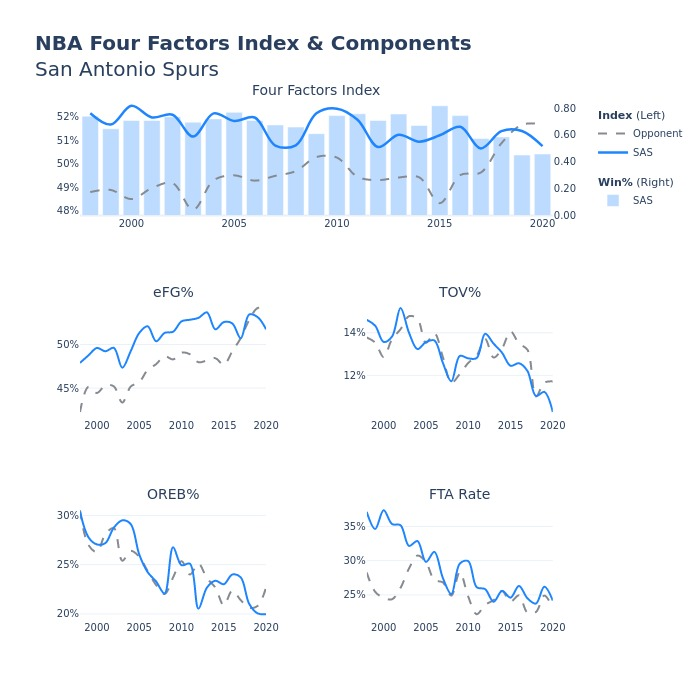

In [3]:
# the analysis was done within Kaggle
# show the visual as a static jpeg
from IPython.display import Image
Image(filename='ffindex.jpeg')

<a id="5"></a> <br>
### 5. Observations

* The 2019-20 season is the first in the observed period in which the Spurs' four factor index is below that of their opponents. This coincides with the Spurs missing the playoffs for the first time in 22 years. 
* A dip in the index occurs in the 2017-18 season, which is the first season after the Spurs traded away Kawhi Leonard, their top all-star.
* Perhaps the most impactful trend is the dramatic increase in their opponents eFG% from 2015 onward. This is due to the well reported and documented 3-point revolution the league has experienced. 
    * Much of the Spurs success can be attributed to an eFG% near or above 50%, which for 20 years was consistently above their competition. Since 2017 the rest of the league has reached a similar eFG% by taking/making more 3 point shots.
* I'd be remiss not to point out the drop in winning pct from 2015 to 2016, which follows the retirement of the greatest power forward of all time and soon-to-be Hall of Famer, Tim Duncan. The impact on the factors is small, but one can argue the impact Tim had late in his career was more intangible and thus not best captured by the four factors.

<a id="6"></a> <br>
### 6. Potential Extensions
A potentially interesting extension would be to analyze the same data for all teams and fit a few models, such as logistic regression or a tree-based model, to validate the weights we've assigned to the four factors.

Additionally, the visual could be well suited for a simple web app that allows users to select their own team and time period.